<a href="https://colab.research.google.com/github/LinasEin/pytorch-notebooks/blob/main/image_compression_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import cv2
from collections import OrderedDict
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [25]:
!wget http://www.cs.albany.edu/~xypan/research/img/Kodak/kodim23.png

--2022-08-16 13:42:40--  http://www.cs.albany.edu/~xypan/research/img/Kodak/kodim23.png
Resolving www.cs.albany.edu (www.cs.albany.edu)... 169.226.16.125
Connecting to www.cs.albany.edu (www.cs.albany.edu)|169.226.16.125|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 557596 (545K) [image/png]
Saving to: ‘kodim23.png.2’

kodim23.png.2       100%[===================>] 544.53K   477KB/s    in 1.1s    

2022-08-16 13:42:43 (477 KB/s) - ‘kodim23.png.2’ saved [557596/557596]



h:512, w:768, hxw:393216


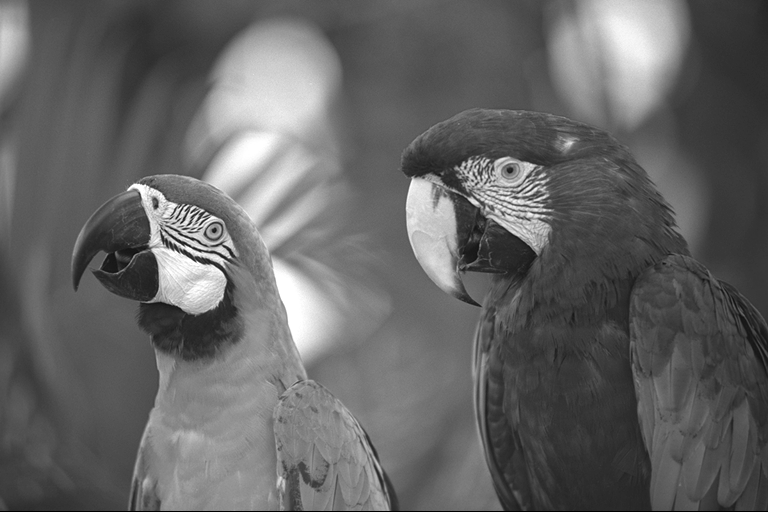

In [26]:
img = Image.open("kodim23.png")
w, h = img.size

# Read as numpy array
img_np = np.array(img)
# Convert to grayscale
img_np = cv2.cvtColor(img_np, cv2.COLOR_BGR2GRAY)
# Number of pixels
n = w * h
print(f'h:{h}, w:{w}, hxw:{n}')
Image.fromarray(img_np)


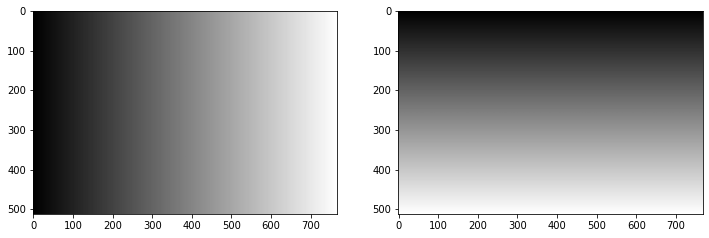

In [27]:
# Training data

# Normalized (between 0 and 1) width and height range
u = np.arange(w)/w
v = np.arange(h)/h

# Set of all pixels
uu, vv = np.meshgrid(u,v)
# stack x and y pixels together into 2d channel
uv  =  np.stack((uu,vv), axis=2)
# ?
uvr = uv.reshape((n,2))
# Flatten the image and normalize?
cr = img_np.reshape((n,1)) / 255.0

fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].imshow(uu, cmap='gray')
ax[1].imshow(vv, cmap='gray')


In [28]:
class SkipLinear(nn.Module):
    def __init__(self, num_hidden):
        super().__init__()
        self.num_hidden = num_hidden
        self.linear = nn.Linear(num_hidden, num_hidden)

    def forward(self, x):
        assert x.size(1) == self.num_hidden
        y = self.linear(x)
        return F.relu(x + y)

class NaiveNet(nn.Module):
    def __init__(self, input_dim, output_dim, num_hidden, num_layers):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_hidden = num_hidden
        self.num_layers = num_layers
        self.backbone = OrderedDict()

        self.backbone['input_linear'] = nn.Linear(input_dim, num_hidden)
        self.backbone['input_act'] = nn.ReLU()

        for i in range(num_layers):
            self.backbone[f"layer_{i}"] = SkipLinear(num_hidden)
        
        self.backbone = nn.Sequential(self.backbone)
        self.head = nn.Linear(num_hidden, output_dim)

    def forward(self, x):
        h = self.backbone(x)
        h = self.head(h)
        y = torch.sigmoid(h)
        return y

In [29]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  else:
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
  def __init__(self, data, device):
    self.data = data
    self.device = device
  
  def __iter__(self):
    for el in self.data:
      yield to_device(el, device)

  def __len__(self):
    return len(self.data)

In [37]:
net = NaiveNet(input_dim=2, output_dim = 1, num_hidden = 96, num_layers=2)
device = get_default_device()
to_device(net, device)

npar = 0
for p in net.parameters():
    print(p.size(), p.numel())
    npar = npar + p.numel()

print(npar)

torch.Size([96, 2]) 192
torch.Size([96]) 96
torch.Size([96, 96]) 9216
torch.Size([96]) 96
torch.Size([96, 96]) 9216
torch.Size([96]) 96
torch.Size([1, 96]) 96
torch.Size([1]) 1
19009


In [38]:
# Normaly we would need DataLoader and we perform mini batch gradient descent
tx  = torch.tensor(uvr, dtype=torch.float32).cuda()
ty  = torch.tensor(cr, dtype=torch.float32).cuda()

criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [41]:
num_global_epoch=1000

epochs = tqdm(range(num_global_epoch))
avg_loss = 1
beta = 0.05

loss_records = list()
net.train()
for epoch in epochs:
    pred = net(tx)
    loss = 10 * criterion(pred, ty)
    
    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()

    avg_loss = (1-beta) * avg_loss + beta * loss.item()
    loss_records.append(loss.item())
    epochs.set_description(f"Epoch {epoch} | Loss {avg_loss: .8f}")

Epoch 999 | Loss  0.04732897: 100%|██████████| 1000/1000 [00:39<00:00, 25.19it/s]


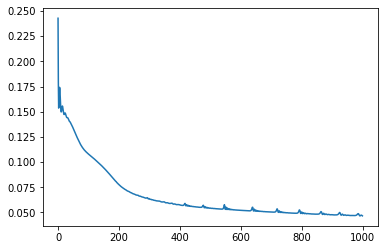

In [42]:
plt.plot(range(num_global_epoch), loss_records)

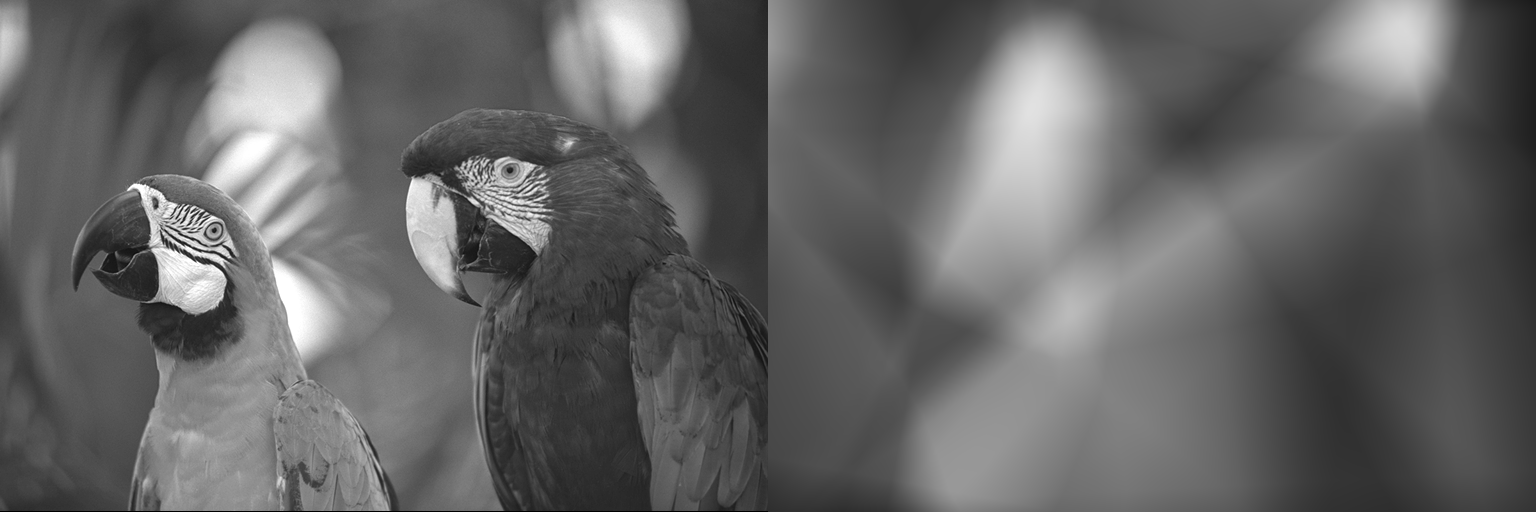

In [43]:
net.eval()
with torch.no_grad():
    p = net(tx)

# Convert back to grayscale intensities
pimg = (255 *  p.cpu().numpy()).astype('uint8')
pimg = pimg.reshape((h,w))

# Print side-by-side
disp = np.concatenate([img_np, pimg], axis=1)
Image.fromarray(disp)